<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/SafeGraph-social-distancing-by-zipcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
colab_requirements = [
    "apt install python3-rtree=0.8.3+ds-1", # rtree v0.8.3
    "pip install geopandas==0.7.0" # geopandas v0.7.0 
]

In [2]:
# following the post, 'Making Jupyter notebooks Google Colab ready'
# https://timsainburg.com/google%20colab.html

import os, sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if 'COLAB_GPU' in os.environ: # a quick and dirty way to check whether this is COLAB
    for i in colab_requirements:
        run_subprocess_command(i)

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
python3-pkg-resources
Suggested packages:
python3-setuptools
The following NEW packages will be installed:
libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 59 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [9

In [3]:
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg
from shapely.geometry import Point

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

from pandas.plotting import scatter_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the census block groups and zipcode boundaries of Chicago

Mapping census block groups to zip code is not trivial and note recommended.

See "Stop Using Zip Codes for Geospatial Analysis", https://carto.com/blog/zip-codes-spatial-analysis/


In [4]:
cook_cbg = gpd.read_file('https://raw.githubusercontent.com/loganpowell/census-geojson/master/GeoJSON/500k/2019/17/block-group.json', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)
# select Cook county
cook_cbg = cook_cbg[cook_cbg.COUNTYFP == '031']
cook_cbg = cook_cbg[['GEOID', 'geometry']]
cook_cbg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3992 entries, 0 to 9688
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     3992 non-null   object  
 1   geometry  3992 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 93.6+ KB


In [5]:
chi_zipcode = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=GeoJSON', # zipcode
                            crs = from_epsg(2163)).to_crs(epsg = 3528)
chi_zipcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    61 non-null     object  
 1   shape_area  61 non-null     object  
 2   shape_len   61 non-null     object  
 3   zip         61 non-null     object  
 4   geometry    61 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 2.5+ KB


In [6]:
chi_cbgzip = gpd.sjoin(cook_cbg, chi_zipcode,
                    how='right',op='intersects').drop("index_left", axis = 1)
chi_cbgzip.info()
#chi_cbgzip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3315 entries, 0 to 60
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       3315 non-null   object  
 1   objectid    3315 non-null   object  
 2   shape_area  3315 non-null   object  
 3   shape_len   3315 non-null   object  
 4   zip         3315 non-null   object  
 5   geometry    3315 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 181.3+ KB


In [7]:
# notice the difference between unique count and # of entries (2329 vs. 3315)?
# many census block groups cross the zip code boundaries ... so it's tricky
print(chi_cbgzip.GEOID.nunique())


2329


## Load the daily census-block-group away-from-home data

After loading the data,
1. Aggregate (summing the device counts) by each month / census-block group
2. Join with zip code, then aggregate by zip code.

In [8]:
# upload the processed file from the local computer
from google.colab import files
uploaded = files.upload()

Saving away_from_home_time_17031.csv.gz to away_from_home_time_17031.csv.gz


In [9]:
# check if the file has been successfully uploaded
!ls

away_from_home_time_17031.csv.gz  sample_data


In [10]:
daily_df = pd.read_csv('./away_from_home_time_17031.csv.gz')
#daily_df.head()
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186394 entries, 0 to 1186393
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   origin_census_block_group  1186394 non-null  int64 
 1   date                       1186394 non-null  object
 2   weekday                    1186394 non-null  int64 
 3   cnt_afh_total              1186394 non-null  int64 
 4   cnt_afh_<20                1186394 non-null  int64 
 5   cnt_afh_21-45              1186394 non-null  int64 
 6   cnt_afh_46-60              1186394 non-null  int64 
 7   cnt_afh_61-120             1186394 non-null  int64 
 8   cnt_afh_121-180            1186394 non-null  int64 
 9   cnt_afh_181-240            1186394 non-null  int64 
 10  cnt_afh_241-300            1186394 non-null  int64 
 11  cnt_afh_301-360            1186394 non-null  int64 
 12  cnt_afh_361-420            1186394 non-null  int64 
 13  cnt_afh_421-480            

In [11]:
# attach month
daily_df['date'] = daily_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [12]:
daily_df['month_year'] = pd.to_datetime(daily_df.date).dt.to_period('M')
daily_df.head(5)

,origin_census_block_group,date,weekday,cnt_afh_total,cnt_afh_<20,cnt_afh_21-45,cnt_afh_46-60,cnt_afh_61-120,cnt_afh_121-180,cnt_afh_181-240,cnt_afh_241-300,cnt_afh_301-360,cnt_afh_361-420,cnt_afh_421-480,cnt_afh_481-540,cnt_afh_541-600,cnt_afh_601-660,cnt_afh_661-720,cnt_afh_721-840,cnt_afh_841-960,cnt_afh_961-1080,cnt_afh_1081-1200,cnt_afh_1201-1320,cnt_afh_1321-1440,month_year
0,170310633032,2019-01-01,1,28,11,0,0,1,3,1,0,0,0,0,1,0,0,2,3,2,1,2,0,1,2019-01
1,170310812024,2019-01-01,1,22,7,1,0,4,2,2,0,0,0,0,0,0,0,0,0,0,5,0,0,1,2019-01
2,170312420003,2019-01-01,1,51,23,3,1,4,5,3,2,0,1,2,1,1,0,0,2,1,1,0,0,1,2019-01
3,170318428005,2019-01-01,1,73,31,3,3,7,7,2,5,2,0,2,1,0,0,0,2,3,1,1,1,2,2019-01
4,170318130001,2019-01-01,1,23,7,1,0,1,7,1,0,0,0,0,1,0,0,0,0,0,1,4,0,0,2019-01


In [13]:
# aggregate by census-block-group and month_year
monthly_df = daily_df.groupby(['origin_census_block_group', 'month_year'], as_index=False).sum()
monthly_df['GEOID'] = monthly_df.origin_census_block_group.astype('str')
monthly_df.head()

,origin_census_block_group,month_year,weekday,cnt_afh_total,cnt_afh_<20,cnt_afh_21-45,cnt_afh_46-60,cnt_afh_61-120,cnt_afh_121-180,cnt_afh_181-240,cnt_afh_241-300,cnt_afh_301-360,cnt_afh_361-420,cnt_afh_421-480,cnt_afh_481-540,cnt_afh_541-600,cnt_afh_601-660,cnt_afh_661-720,cnt_afh_721-840,cnt_afh_841-960,cnt_afh_961-1080,cnt_afh_1081-1200,cnt_afh_1201-1320,cnt_afh_1321-1440,GEOID
0,170310101001,2019-01,90,1207,549,65,21,51,57,53,29,39,36,37,47,43,22,25,28,43,31,8,9,14,170310101001
1,170310101001,2019-02,84,972,467,30,24,43,32,33,27,29,27,32,38,28,30,24,29,30,20,11,10,8,170310101001
2,170310101001,2019-03,99,936,386,47,22,46,34,34,39,33,32,18,46,18,23,29,37,28,23,18,12,11,170310101001
3,170310101001,2019-04,85,1044,331,63,35,59,41,55,50,33,19,47,41,38,29,19,31,36,30,26,14,47,170310101001
4,170310101001,2019-05,93,1000,336,50,32,60,63,38,44,41,36,35,34,32,22,14,33,34,23,36,20,17,170310101001


In [14]:
# join with zipcode
monthly_df = pd.merge(monthly_df, chi_cbgzip, 
                      left_on = "GEOID", right_on = "GEOID", 
                      how = "right")
#monthly_df.head()
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56133 entries, 0 to 56132
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   origin_census_block_group  56122 non-null  float64  
 1   month_year                 56122 non-null  period[M]
 2   weekday                    56122 non-null  float64  
 3   cnt_afh_total              56122 non-null  float64  
 4   cnt_afh_<20                56122 non-null  float64  
 5   cnt_afh_21-45              56122 non-null  float64  
 6   cnt_afh_46-60              56122 non-null  float64  
 7   cnt_afh_61-120             56122 non-null  float64  
 8   cnt_afh_121-180            56122 non-null  float64  
 9   cnt_afh_181-240            56122 non-null  float64  
 10  cnt_afh_241-300            56122 non-null  float64  
 11  cnt_afh_301-360            56122 non-null  float64  
 12  cnt_afh_361-420            56122 non-null  float64  
 13  cnt_afh_421-480 

In [15]:
# aggregate by zip code and month_year
zipcode_df = monthly_df.groupby(['zip', 'month_year'], as_index=False).sum()
zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1002
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   zip                        1003 non-null   object   
 1   month_year                 1003 non-null   period[M]
 2   origin_census_block_group  1003 non-null   float64  
 3   weekday                    1003 non-null   float64  
 4   cnt_afh_total              1003 non-null   float64  
 5   cnt_afh_<20                1003 non-null   float64  
 6   cnt_afh_21-45              1003 non-null   float64  
 7   cnt_afh_46-60              1003 non-null   float64  
 8   cnt_afh_61-120             1003 non-null   float64  
 9   cnt_afh_121-180            1003 non-null   float64  
 10  cnt_afh_181-240            1003 non-null   float64  
 11  cnt_afh_241-300            1003 non-null   float64  
 12  cnt_afh_301-360            1003 non-null   float64  
 13  cnt_afh_361-420   

In [16]:
zipcode_df.head()


,zip,month_year,origin_census_block_group,weekday,cnt_afh_total,cnt_afh_<20,cnt_afh_21-45,cnt_afh_46-60,cnt_afh_61-120,cnt_afh_121-180,cnt_afh_181-240,cnt_afh_241-300,cnt_afh_301-360,cnt_afh_361-420,cnt_afh_421-480,cnt_afh_481-540,cnt_afh_541-600,cnt_afh_601-660,cnt_afh_661-720,cnt_afh_721-840,cnt_afh_841-960,cnt_afh_961-1080,cnt_afh_1081-1200,cnt_afh_1201-1320,cnt_afh_1321-1440
0,60601,2019-01,1.362504e+12,720.0,46611.0,21511.0,2368.0,918.0,2866.0,2249.0,1827.0,1690.0,1858.0,1604.0,1328.0,1306.0,1052.0,833.0,604.0,1151.0,894.0,886.0,574.0,557.0,535.0
1,60601,2019-02,1.362504e+12,672.0,42992.0,18659.0,1994.0,781.0,2678.0,2115.0,1835.0,1627.0,1812.0,1463.0,1504.0,1471.0,1097.0,967.0,757.0,1151.0,817.0,818.0,522.0,499.0,425.0
2,60601,2019-03,1.362504e+12,792.0,51915.0,21602.0,2739.0,1086.0,3404.0,2705.0,2257.0,2614.0,2400.0,1823.0,1663.0,1677.0,1320.0,1034.0,876.0,1319.0,1046.0,838.0,641.0,504.0,367.0
3,60601,2019-04,1.362504e+12,680.0,59565.0,24040.0,3026.0,1236.0,3958.0,3114.0,2793.0,3194.0,2643.0,1999.0,2042.0,1961.0,1637.0,1257.0,989.0,1563.0,1200.0,965.0,888.0,601.0,459.0
4,60601,2019-05,1.362504e+12,744.0,71926.0,29996.0,4394.0,1730.0,5317.0,3732.0,3351.0,3342.0,2542.0,2293.0,2211.0,2170.0,1783.0,1375.0,1129.0,1706.0,1308.0,1188.0,1057.0,741.0,561.0


## Get the mean away-from-home time for each zip code and month_year

**HOWEVER, the overall mean is very misleading** because the away-from-home time of the people who stayed more than 12 hours away-from-home actually increased after 2020 April. I will illustrate this trend below.

To address this, I simply divided the 'devices' into to groups, less-than-12h (`afh_keys-low`) and more-than-12h (`afh_keys-high`) away-from-home time, and calculated the mean away-from-home time for each.

In [17]:
afh_keys_low = ['<20', '21-45', '46-60', '61-120', '121-180',
                '181-240', '241-300', '301-360', '361-420', '421-480',
                '481-540', '541-600', '601-660', '661-720']
afh_keys_high = ['721-840', '841-960', '961-1080', '1081-1200', '1201-1320', '1321-1440']

afh_val = {'<20':10, '21-45':33, '46-60':54, '61-120':90, '121-180':150,
           '181-240':210, '241-300':270, '301-360':330, '361-420':390, '421-480':450,
           '481-540':510, '541-600':570, '601-660':630, '661-720':690, '721-840':780, 
           '841-960':900, '961-1080':1020, '1081-1200':1140, '1201-1320':1260, '1321-1440':1380}

In [19]:
# counting the # of devices
zipcode_df['devcnt_all'] = zipcode_df['cnt_afh_<20']
zipcode_df['devcnt_low'] = zipcode_df['cnt_afh_<20']
zipcode_df['devcnt_high'] = zipcode_df['cnt_afh_721-840']

for key in afh_keys_low[1:]:
    zipcode_df['devcnt_all'] += zipcode_df['cnt_afh_' + key]
    zipcode_df['devcnt_low'] += zipcode_df['cnt_afh_' + key]
    
for key in afh_keys_high[1:]:
    zipcode_df['devcnt_all'] += zipcode_df['cnt_afh_' + key]
    zipcode_df['devcnt_high'] += zipcode_df['cnt_afh_' + key]

print(zipcode_df.devcnt_low.describe())
print('-----------------')
print(zipcode_df.devcnt_high.describe())

count      1003.000000
mean     105646.620140
std       55728.912272
min        7532.000000
25%       69566.000000
50%       98077.000000
75%      137736.500000
max      423673.000000
Name: devcnt_low, dtype: float64
-----------------
count     1003.000000
mean     10183.483549
std       4475.582328
min       1099.000000
25%       7401.000000
50%       9854.000000
75%      12983.000000
max      35265.000000
Name: devcnt_high, dtype: float64


In [20]:
#afh_keys[1:]
#afh_val['<20']
zipcode_df['mean_afh_all'] = zipcode_df['cnt_afh_<20'] * afh_val['<20'] / zipcode_df['devcnt_all']
zipcode_df['mean_afh_low'] = zipcode_df['cnt_afh_<20'] * afh_val['<20'] / zipcode_df['devcnt_low']
zipcode_df['mean_afh_high'] = zipcode_df['cnt_afh_721-840'] * afh_val['721-840'] / zipcode_df['devcnt_high']

for key in afh_keys_low[1:]:
    zipcode_df['mean_afh_all'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_all']
    zipcode_df['mean_afh_low'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_low']

for key in afh_keys_high[1:]:
    zipcode_df['mean_afh_all'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_all']
    zipcode_df['mean_afh_high'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_high']

print(zipcode_df.mean_afh_low.describe())
print('--------------------')
print(zipcode_df.mean_afh_high.describe())

count    1003.000000
mean      149.711649
std        23.341634
min        84.657669
25%       139.619011
50%       150.409305
75%       162.943642
max       211.069481
Name: mean_afh_low, dtype: float64
--------------------
count    1003.000000
mean     1040.843048
std        44.512778
min       977.643732
25%      1010.870670
50%      1026.812996
75%      1055.355599
max      1260.177712
Name: mean_afh_high, dtype: float64


In [21]:
zipcode_df.head(10)

,zip,month_year,origin_census_block_group,weekday,cnt_afh_total,cnt_afh_<20,cnt_afh_21-45,cnt_afh_46-60,cnt_afh_61-120,cnt_afh_121-180,cnt_afh_181-240,cnt_afh_241-300,cnt_afh_301-360,cnt_afh_361-420,cnt_afh_421-480,cnt_afh_481-540,cnt_afh_541-600,cnt_afh_601-660,cnt_afh_661-720,cnt_afh_721-840,cnt_afh_841-960,cnt_afh_961-1080,cnt_afh_1081-1200,cnt_afh_1201-1320,cnt_afh_1321-1440,devcnt_low,devcnt_high,devcnt_all,mean_afh_all,mean_afh_low,mean_afh_high
0,60601,2019-01,1.362504e+12,720.0,46611.0,21511.0,2368.0,918.0,2866.0,2249.0,1827.0,1690.0,1858.0,1604.0,1328.0,1306.0,1052.0,833.0,604.0,1151.0,894.0,886.0,574.0,557.0,535.0,42014.0,4597.0,45460.0,211.712187,138.564193,1022.532086
1,60601,2019-02,1.362504e+12,672.0,42992.0,18659.0,1994.0,781.0,2678.0,2115.0,1835.0,1627.0,1812.0,1463.0,1504.0,1471.0,1097.0,967.0,757.0,1151.0,817.0,818.0,522.0,499.0,425.0,38760.0,4232.0,41841.0,224.894864,155.568782,1010.812854
2,60601,2019-03,1.362504e+12,792.0,51915.0,21602.0,2739.0,1086.0,3404.0,2705.0,2257.0,2614.0,2400.0,1823.0,1663.0,1677.0,1320.0,1034.0,876.0,1319.0,1046.0,838.0,641.0,504.0,367.0,47200.0,4715.0,50596.0,218.202249,156.181377,996.229056
3,60601,2019-04,1.362504e+12,680.0,59565.0,24040.0,3026.0,1236.0,3958.0,3114.0,2793.0,3194.0,2643.0,1999.0,2042.0,1961.0,1637.0,1257.0,989.0,1563.0,1200.0,965.0,888.0,601.0,459.0,53889.0,5676.0,58002.0,226.281025,160.653417,1001.839323
4,60601,2019-05,1.362504e+12,744.0,71926.0,29996.0,4394.0,1730.0,5317.0,3732.0,3351.0,3342.0,2542.0,2293.0,2211.0,2170.0,1783.0,1375.0,1129.0,1706.0,1308.0,1188.0,1057.0,741.0,561.0,65365.0,6561.0,70220.0,213.342239,148.077901,1010.891632
5,60601,2019-06,1.362504e+12,760.0,77316.0,31343.0,5676.0,2165.0,6872.0,4705.0,3438.0,3181.0,2285.0,2087.0,2097.0,2088.0,1729.0,1489.0,1156.0,1781.0,1472.0,1419.0,1151.0,698.0,484.0,70311.0,7005.0,75535.0,204.570040,139.672000,1002.269807
6,60601,2019-07,1.362504e+12,696.0,79948.0,31666.0,6791.0,2575.0,7371.0,4986.0,3433.0,3042.0,2145.0,2017.0,2090.0,2059.0,1743.0,1487.0,1194.0,1877.0,1544.0,1346.0,1156.0,796.0,630.0,72599.0,7349.0,78071.0,202.704500,135.988416,1009.223024
7,60601,2019-08,1.362504e+12,768.0,67036.0,26880.0,5078.0,1897.0,5402.0,3728.0,3016.0,2699.0,1987.0,1848.0,1882.0,1906.0,1619.0,1289.0,1121.0,1714.0,1309.0,1301.0,1044.0,767.0,549.0,60352.0,6684.0,65322.0,215.385046,143.326849,1010.807899
8,60601,2019-09,1.362504e+12,720.0,69245.0,30105.0,4433.0,1632.0,4908.0,3696.0,2993.0,2804.0,2138.0,2044.0,2209.0,2119.0,1706.0,1321.0,958.0,1650.0,1351.0,1107.0,966.0,625.0,480.0,63066.0,6179.0,67595.0,204.992781,142.078251,1000.676485
9,60601,2019-10,1.362504e+12,720.0,63315.0,27620.0,4140.0,1498.0,4345.0,3212.0,2739.0,2528.0,1909.0,1882.0,1995.0,1938.0,1610.0,1163.0,1055.0,1504.0,1167.0,1077.0,795.0,605.0,533.0,57634.0,5681.0,61811.0,207.175292,143.192074,1007.938743


## Make the summary tables

In [22]:
# rows: month_year, columns: zip code
#zipsumm_low = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_low' ).reset_index()
zipsumm_all = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_all' )
zipsumm_low = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_low' )
zipsumm_low.head(10)

zip,60601,60602,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612,60613,60614,60615,60616,60617,60618,60619,60620,60621,60622,60623,60624,60625,60626,60628,60629,60630,60631,60632,60633,60634,60636,60637,60638,60639,60640,60641,60642,60643,60644,60645,60646,60647,60649,60651,60652,60653,60654,60655,60656,60657,60659,60660,60661,60666,60707,60827
month_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01,138.564193,134.120702,125.999017,126.883735,134.486678,133.576334,136.748404,133.695207,126.003728,145.879257,146.854881,130.209713,135.222445,145.207015,134.906345,139.296623,123.764688,136.854159,122.902619,123.498887,120.027808,131.594642,121.796243,126.820676,137.897958,127.379018,120.987530,126.284029,150.034747,164.571672,128.696775,126.470012,146.227396,115.746823,127.020940,139.187762,130.199736,125.922782,138.992139,141.461085,129.532562,133.375931,128.757388,161.995179,129.246457,123.381710,126.053624,133.736178,130.644010,142.682230,157.533838,162.913101,138.767540,132.945229,130.758173,139.783885,150.369604,143.065079,118.418349
2019-02,155.568782,151.075822,143.076394,142.121484,152.785282,147.847250,134.462216,134.550243,141.364843,161.751988,165.701654,145.123463,152.402584,163.096358,152.499848,138.616807,138.448456,154.082621,138.286774,139.323911,130.523944,146.793656,134.680029,136.594890,154.155957,143.586360,136.863809,139.593576,169.185273,185.463934,136.091010,144.643412,163.661394,128.456691,139.435899,158.755845,147.521342,138.513476,155.189151,158.264711,143.585378,141.137538,141.989776,180.520768,141.399085,135.525908,137.175182,152.369087,148.308448,157.431383,182.169438,180.270258,157.194486,147.646350,148.807378,157.443718,168.958902,160.691787,133.988967
2019-03,156.181377,150.773415,146.700241,147.378097,154.285629,153.811293,141.498496,141.669022,148.230718,162.230798,166.761864,152.707173,152.635820,163.865886,154.466913,144.205766,143.340757,157.621693,145.840734,146.807471,139.701796,151.548012,137.125803,143.595426,161.787726,147.192944,144.162414,146.226896,175.720369,188.589369,147.557223,149.118502,169.300859,137.301755,140.761372,167.419491,154.587807,144.142223,161.522936,159.287665,150.418690,146.115096,150.003710,181.852625,147.895056,144.215952,143.094038,160.602817,156.613655,159.746948,183.926824,185.109999,159.573858,153.931866,152.720931,156.843243,176.643925,166.237888,141.807671
2019-04,160.653417,153.532252,150.750726,150.738819,157.421188,156.831823,140.202063,141.084069,153.938679,160.027029,170.411364,153.851211,152.412045,161.307718,156.986325,144.941130,147.722756,159.943257,150.955872,148.367991,141.513676,152.401041,139.035676,146.019408,163.883305,153.557792,149.307777,149.721484,174.363179,189.723057,152.394730,152.677699,169.897447,141.662955,142.565632,170.278678,158.401423,145.655623,163.808505,157.664811,153.685373,150.164515,155.140639,183.049415,150.655621,147.918740,147.985743,164.927138,159.435597,162.182392,186.069116,183.878501,157.184139,157.472414,155.700713,155.841535,180.454641,168.231335,144.627741
2019-05,148.077901,142.120052,139.929137,141.838318,151.570309,146.303161,136.935293,143.908838,161.173426,150.783629,160.129645,156.226642,147.291320,153.840366,158.043488,146.030336,151.809589,161.543024,156.101303,154.938982,147.836998,149.577174,138.764107,147.320485,165.809834,149.100688,155.336702,153.276835,178.021945,187.440159,160.616533,159.983075,175.950540,145.956727,141.409795,173.228985,161.983090,145.324661,167.495904,153.925100,158.258652,153.495234,158.669478,182.094969,150.379867,150.587861,151.176489,174.772843,164.081137,151.463998,182.360455,184.667553,149.195630,160.676393,149.195595,141.514602,183.807436,174.560528,149.230096
2019-06,139.672000,139.742580,136.293295,138.460218,146.480013,138.560884,132.051554,141.018251,154.727588,140.435893,150.443849,149.000988,135.770524,142.167583,151.417354,145.060137,143.196956,153.652399,146.364857,148.469425,141.294170,140.620324,132.516172,141.815782,157.200828,143.

In [28]:
zipsumm_all.head(20)

zip,60601,60602,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612,60613,60614,60615,60616,60617,60618,60619,60620,60621,60622,60623,60624,60625,60626,60628,60629,60630,60631,60632,60633,60634,60636,60637,60638,60639,60640,60641,60642,60643,60644,60645,60646,60647,60649,60651,60652,60653,60654,60655,60656,60657,60659,60660,60661,60666,60707,60827
month_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01,211.712187,207.022481,194.473881,192.247354,197.811190,196.892705,227.428166,206.810267,177.591747,220.960504,228.468884,194.277730,187.685204,210.298338,197.864043,225.018450,175.733462,187.154199,177.963620,179.857321,178.983220,187.679617,174.661216,195.567644,188.214584,180.665455,179.073264,185.882012,203.507764,228.508528,181.837479,173.319926,197.911131,169.401011,189.501444,200.251628,176.973632,173.515788,193.549567,200.364531,186.007567,202.324088,180.796584,220.522180,183.019597,179.274858,178.371045,183.025407,193.153622,213.497887,218.554904,225.379082,198.119032,183.282118,189.958442,203.885740,202.904083,190.321974,171.367306
2019-02,224.894864,220.453798,208.543508,204.296640,213.698122,206.227993,201.480818,192.854502,192.772272,234.259817,245.634926,201.557438,204.488167,228.196879,209.016992,203.734435,187.940242,203.186899,191.696298,191.325353,187.675139,200.234883,185.770771,195.319619,199.983440,189.215679,193.406876,196.524890,219.370928,245.114746,187.799112,194.601323,207.054528,182.129831,193.284107,214.692879,192.533122,185.032353,204.752175,218.070966,194.882941,193.219229,188.198084,235.030644,190.695776,187.355888,185.310196,198.209986,204.782553,225.884831,237.431012,235.414228,215.701422,194.649392,196.772661,218.278622,217.389592,202.443256,186.224072
2019-03,218.202249,222.827251,223.279810,221.101203,223.325620,214.315307,225.855054,210.419184,199.791925,236.611721,239.329599,208.131538,205.136778,228.771919,218.113855,220.909033,194.122820,206.288085,200.272973,200.515704,197.237691,202.288464,188.928335,204.134603,209.400453,203.447157,200.322162,205.948796,227.038368,251.597998,203.269921,200.773246,214.725559,192.927132,199.500329,228.398290,200.763370,191.045066,209.355725,218.073349,203.220746,199.442394,194.750114,236.914912,195.511976,193.876837,194.291507,210.930076,216.340986,223.481686,242.475653,242.781751,216.729518,200.524054,217.112404,224.955530,232.647828,211.099553,196.492900
2019-04,226.281025,220.358742,214.627550,213.756942,217.913690,215.761955,204.928644,200.692899,208.987057,229.027114,247.026097,216.706939,206.546779,222.858299,215.414317,210.254308,202.367161,213.338024,210.695039,208.770467,205.096343,206.625387,191.125441,211.485821,217.537888,208.084792,211.048037,208.678714,232.357482,255.429997,207.460158,207.934448,219.056437,200.075827,197.231551,233.086517,205.494379,194.723333,215.768890,214.844548,216.186018,206.355458,207.008782,246.759420,202.135238,206.489652,202.151668,218.939479,223.658165,224.020470,254.059774,241.361624,213.195864,208.419299,211.883358,215.373496,235.624577,220.369203,202.687404
2019-05,213.342239,224.900105,226.523739,227.787645,231.560286,206.631990,212.064860,207.654393,219.493598,221.041390,235.831712,220.407746,199.448132,211.468428,216.159477,214.834231,206.796521,210.975422,214.707959,213.523920,207.982171,203.225864,185.415264,205.611180,216.793987,202.570658,215.321919,209.014479,232.908195,247.325661,214.555002,212.859307,223.036207,205.378494,191.935977,230.757504,206.699419,193.472185,217.136728,210.804151,218.033229,208.840795,205.885372,236.810500,201.578353,206.500549,200.592358,229.597399,230.671366,216.094541,241.951330,239.456645,204.516036,209.477435,204.140850,200.948258,242.426209,218.179172,201.362378
2019-06,204.570040,207.185731,199.275096,201.896636,212.299537,196.670742,199.048317,203.196890,212.986412,205.481384,228.566291,217.576587,190.955875,214.726386,228.008977,212.488621,202.142974,207.938794,208.191848,213.535515,211.531020,198.275330,182.077057,204.784701,209.169226,196.

In [23]:
# rows: month_year, columns: zip code
zipsumm_high = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_high' ) #.reset_index()
zipsumm_high

zip,60601,60602,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612,60613,60614,60615,60616,60617,60618,60619,60620,60621,60622,60623,60624,60625,60626,60628,60629,60630,60631,60632,60633,60634,60636,60637,60638,60639,60640,60641,60642,60643,60644,60645,60646,60647,60649,60651,60652,60653,60654,60655,60656,60657,60659,60660,60661,60666,60707,60827
month_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01,1022.532086,1029.976744,1022.259077,1016.662909,1026.007989,1008.328351,1054.179193,1047.551362,1020.015630,1029.827586,1029.010003,1033.561606,1015.018669,1019.857333,1038.279085,1054.451504,1024.085526,1005.324047,1027.298398,1026.642780,1032.202703,1020.000000,1008.586804,1031.379437,1002.850421,1017.991392,1030.834598,1026.815269,1017.722612,1024.158416,998.494188,1008.874494,1009.296088,1028.711294,1036.474089,1017.412892,1002.878957,1007.625272,1009.819357,1010.578856,1028.099850,1027.866259,1020.475495,1025.799033,1016.744640,1030.648541,1019.009758,1020.259873,1040.940647,1011.378756,1023.897077,1020.498143,1017.920065,1015.389972,1031.831569,1025.666105,1009.059334,1010.092251,1013.766800
2019-02,1010.812854,1013.354596,1001.948718,999.275148,1005.727088,986.158584,1023.100265,1020.713333,1011.717999,1012.490166,1019.984698,1006.565490,994.495021,1006.980477,1017.139597,1028.011433,1006.496956,992.248460,1010.134709,999.733157,1021.550938,998.802246,982.836200,1007.809818,988.069319,992.329193,1016.783314,1010.849707,995.861643,1005.883234,1007.523308,1015.123675,990.152067,1015.599022,996.348199,1006.919275,979.165652,991.823401,984.463890,1000.133664,1007.768404,1003.966406,993.947066,996.316368,994.656078,1008.879904,993.768456,993.304348,1014.302719,998.746772,1001.110951,997.976654,1002.458805,999.129730,996.252529,1004.130510,979.851301,997.795187,1015.342137
2019-03,996.229056,1011.773969,1010.296296,1009.222310,1016.998376,994.867404,1051.478803,1040.262134,1008.088658,1017.605487,1011.231275,1003.573201,1001.526766,1012.683544,1028.691964,1050.448994,1003.624585,988.373576,1010.771902,1003.300302,1015.659481,991.615202,987.166089,1007.373196,993.585903,1022.253219,1010.400000,1007.916120,1001.894576,1008.798786,1015.300504,995.028618,989.273021,1013.709986,1007.396008,1016.321579,977.643732,995.294428,982.850780,1002.269764,1010.232709,1004.188235,995.865922,1012.552011,993.737161,998.729858,996.647805,1007.098790,1019.310775,995.597636,1007.878008,1000.881723,1002.961409,993.219736,1033.584672,1029.371490,994.063401,997.928606,1002.490949
2019-04,1001.839323,1019.046322,1015.278155,1010.696629,1013.288653,994.534281,1021.896020,1023.895836,1016.585160,1017.103998,1016.851091,1022.684510,1007.604177,1011.840513,1020.872673,1027.862095,1016.263959,1007.919371,1016.787714,1022.194984,1030.366724,1009.418277,999.721243,1024.774676,1006.564570,1018.890985,1025.079695,1014.967647,1016.345970,1018.308624,1018.384647,1019.318480,1009.107818,1025.085020,1012.491228,1022.353953,997.613514,1002.843643,1006.142774,1000.851492,1032.959854,1023.993265,1012.429022,1025.128205,1008.827394,1026.950384,1011.102504,1015.581306,1022.446289,994.200676,1030.498229,1007.209455,1010.673663,1008.704174,1016.013514,1007.454545,992.411576,1020.262467,1028.645262
2019-05,1010.891632,1034.478449,1039.029554,1038.879755,1042.503195,1007.250509,1040.323812,1029.183114,1023.429926,1027.677270,1021.968732,1021.022472,1006.734554,1014.404908,1018.169444,1033.423337,1017.118741,997.050396,1023.955018,1019.567412,1018.456872,1007.499112,984.583696,1012.569098,1005.478691,1017.516441,1021.522643,1010.133312,1011.507315,1009.224987,1012.483624,1016.652789,999.540124,1024.108761,1007.531735,1013.489736,988.884485,1005.593276,995.876364,1005.865791,1024.112114,1014.377811,1005.603348,1012.630752,1006.965269,1016.106338,1003.826899,1019.445593,1031.703180,1008.061790,1020.298755,997.128226,1012.211613,1006.328380,1021.518443,1023.396520,990.728571,998.107265,1007.496038
2019-06,1002.269807,1005.151311,996.686831,997.7512

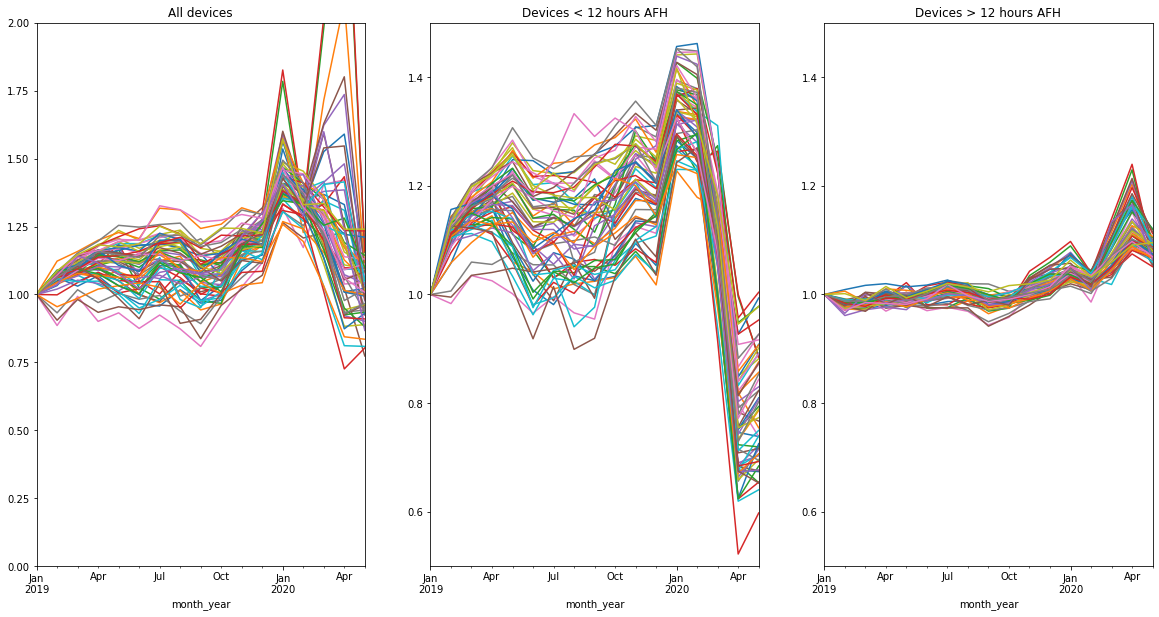

In [29]:
fig, ax = plt.subplots(1,3, figsize=(20,10))

(zipsumm_all/zipsumm_all.loc['2019-01']).plot(legend=False, ax=ax[0], ylim=[0,2], title='All devices')
(zipsumm_low/zipsumm_low.loc['2019-01']).plot(legend=False, ax=ax[1], ylim=[.5,1.5], title='Devices < 12 hours AFH')
(zipsumm_high/zipsumm_high.loc['2019-01']).plot(legend=False, ax=ax[2], ylim=[.5,1.5], title='Devices > 12 hours AFH')

In [30]:
zipratio_df = pd.DataFrame({'Low_April':[], 'Low_May':[], 'High_April':[], 'High_May':[]})
zipratio_df['Low_April'] = zipsumm_low.loc['2020-04'] / zipsumm_low.loc['2019-04']
zipratio_df['Low_May'] = zipsumm_low.loc['2020-05'] / zipsumm_low.loc['2019-05']
zipratio_df['High_April'] = zipsumm_high.loc['2020-04'] / zipsumm_high.loc['2019-04']
zipratio_df['High_May'] = zipsumm_high.loc['2020-05'] / zipsumm_high.loc['2019-05']
zipratio_df['All_April'] = zipsumm_all.loc['2020-04'] / zipsumm_all.loc['2019-04']
zipratio_df['All_May'] = zipsumm_all.loc['2020-05'] / zipsumm_all.loc['2019-05']

In [32]:
zipratio_df.head(10)

,Low_April,Low_May,High_April,High_May,All_April,All_May
zip,,,,,,
60601,0.643645,0.691312,1.204118,1.108902,1.487774,1.101586
60602,0.715879,0.712264,1.216153,1.078124,1.951938,1.007401
60603,0.832370,0.797745,1.237757,1.057664,2.433319,0.990941
60604,0.841951,0.789888,1.246841,1.052160,2.460355,0.977641
60605,0.589806,0.624035,1.223909,1.077932,1.575625,0.859216
60606,0.667212,0.700458,1.230271,1.099478,1.643415,1.029700
60607,0.779616,0.737375,1.188294,1.081597,1.577338,0.934340
60608,0.749963,0.764588,1.151060,1.071616,1.221566,0.944679
60609,0.687843,0.704792,1.128726,1.077641,0.982546,0.897178


## create csv files and download

In [ ]:
zipsumm_low.to_csv('zipsumm_low.csv')
zipsumm_high.to_csv('zipsumm_high.csv')
zipratio_df.to_csv('zip_ratio.csv')

In [ ]:
# download the files
files.download('zipsumm_low.csv')
files.download('zipsumm_high.csv')
files.download('zip_ratio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Merge the zip_ratio with the chi_zipcode

So that we can see the spatial distribution

In [ ]:
# merge the social distancing and zipcode
zipratio_gdf = pd.merge(chi_zipcode, zipratio_df, left_on='zip', right_on='zip')
#zipratio_gdf.head()
zipratio_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    61 non-null     object  
 1   shape_area  61 non-null     object  
 2   shape_len   61 non-null     object  
 3   zip         61 non-null     object  
 4   geometry    61 non-null     geometry
 5   Low_April   61 non-null     float64 
 6   Low_May     61 non-null     float64 
 7   High_April  61 non-null     float64 
 8   High_May    61 non-null     float64 
dtypes: float64(4), geometry(1), object(4)
memory usage: 4.8+ KB


In [ ]:
# merge the social distancing and zipcode
zipsumm_low_gdf = pd.merge(chi_zipcode, zipsumm_low.T, left_on='zip', right_on='zip')
zipsumm_high_gdf = pd.merge(chi_zipcode, zipsumm_high.T, left_on='zip', right_on='zip')
#zipratio_gdf.head()
zipsumm_low_gdf.describe()

,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,134.566428,149.525445,154.617625,156.936650,156.884624,149.573461,150.808932,149.970490,152.063835,156.310171,162.682010,159.210565,180.586677,177.645604,148.691086,102.353077,106.405308
std,10.774141,13.203366,12.134733,11.594729,12.654306,12.321594,12.682754,14.567808,15.322936,16.751715,15.925765,14.673444,12.987919,13.174258,7.653492,9.111850,9.421497
min,115.746823,128.456691,137.125803,139.035676,136.935293,128.399066,129.902143,125.680626,128.528874,130.832010,135.996566,130.683000,157.893385,154.337310,132.118498,84.657669,87.502109
25%,126.820676,139.323911,146.115096,149.721484,148.077901,140.534608,141.817059,140.684464,140.931567,145.765534,152.233781,148.622235,170.595422,168.423913,143.049053,95.561496,99.008580
50%,133.375931,147.521342,152.635820,153.938679,153.840366,147.248554,147.731945,146.914095,146.771853,150.977275,158.853409,156.038445,178.966126,175.639642,147.265582,102.009687,107.014122
75%,139.296623,157.431383,160.602817,161.307718,161.543024,157.200828,157.128746,156.429963,160.716072,163.840081,169.225435,166.800304,188.423504,187.646048,155.120006,109.192506,114.595193
max,164.571672,185.463934,188.589369,189.723057,187.440159,178.555471,187.348566,200.396487,194.094254,199.177691,198.592850,193.498768,211.069481,203.353043,162.009480,126.914690,126.882741


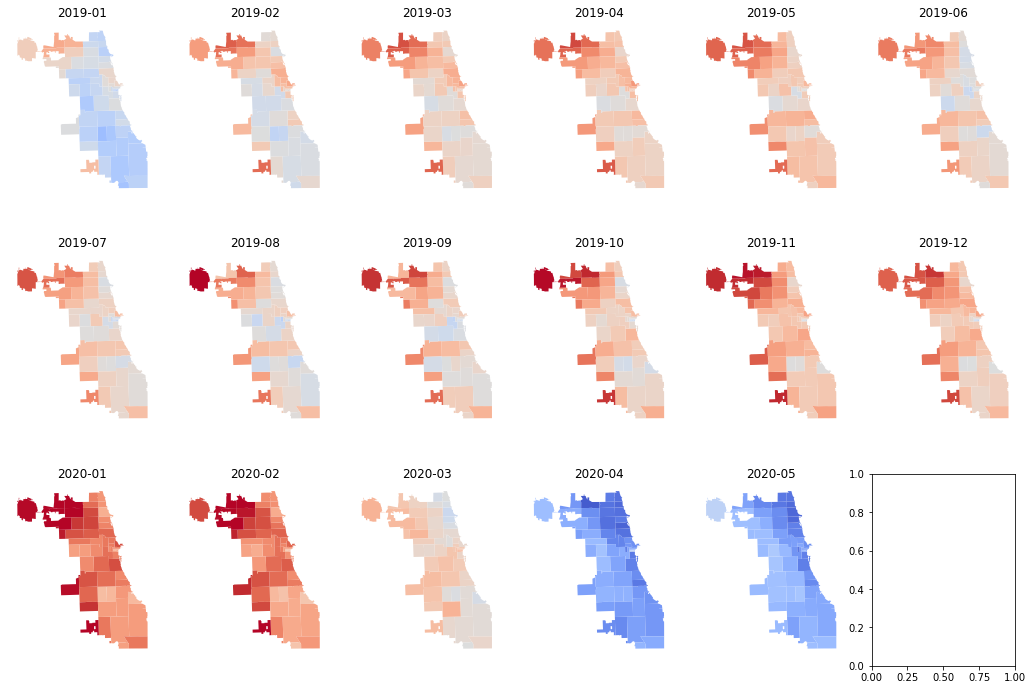

In [ ]:
fig, ax = plt.subplots(3,6, figsize=(18,12))
ax = ax.flatten()

for ii in range(17):
    bx = zipsumm_low_gdf.plot(column = zipsumm_low_gdf.columns[5+ii], 
                              vmin = 80, vmax = 200, cmap = "coolwarm", ax = ax[ii])
   
    bx.set_title(str(zipsumm_low_gdf.columns[5+ii]), fontsize=12)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)


In [ ]:
  zipratio_gdf.describe()
  #zipratio_gdf.info()

,Low_April,Low_May,High_April,High_May
count,61.000000,61.000000,61.000000,61.000000
mean,0.656437,0.681243,1.135987,1.090659
std,0.083003,0.070711,0.047213,0.015833
min,0.462485,0.532008,1.075207,1.052160
25%,0.600553,0.623689,1.096837,1.078444
50%,0.633680,0.683013,1.118563,1.089220
75%,0.711108,0.721790,1.174339,1.100937
max,0.841951,0.858570,1.246841,1.126403


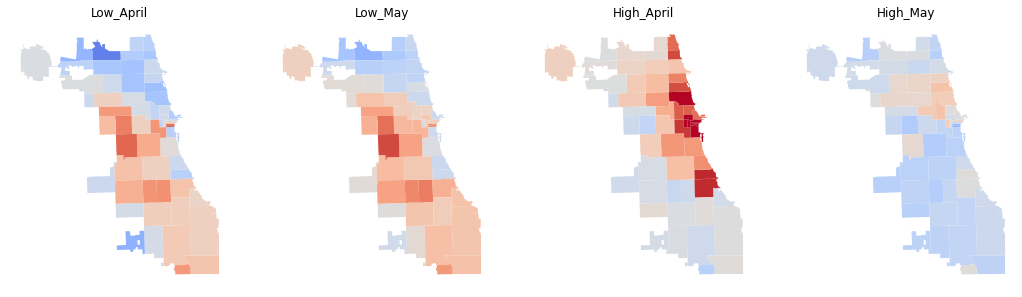

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(18,6))
ax = ax.flatten()

for ii in range(4):
    if (ii < 2):
      bx = zipratio_gdf.plot(column = zipratio_gdf.columns[5+ii], 
                             vmin = 0.4, vmax = .9, cmap = "coolwarm", ax = ax[ii])
    else:
      bx = zipratio_gdf.plot(column = zipratio_gdf.columns[5+ii], 
                             vmin = 1, vmax = 1.2, cmap = "coolwarm", ax = ax[ii])
   
    bx.set_title(str(zipratio_gdf.columns[5+ii]), fontsize=12)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)